**Mount Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, RobertaModel, RobertaTokenizer, RobertaConfig
from peft import get_peft_model, LoraConfig, TaskType
import re
import string
from nltk.corpus import stopwords, wordnet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from collections import Counter
import numpy as np
import random
import nltk
import torch
from torch.utils.data import Dataset

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Import Data**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/URECA_Assessment_Project/Dataset/Train.csv")

In [ ]:
print(data.head().to_string())

   Unnamed: 0         id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
data.shape

(262, 18)

**Data Visualization**

In [ ]:
label_columns = data.columns[4:]

data[label_columns].sum().sort_values(ascending=False)

,0
Help-Seeking,132
Well-being,66
career,42
Grading,30
Peer Support,27
standards,15
Transparency,14
structure,8
GroupWork,4
Socio-economic background and parents,4


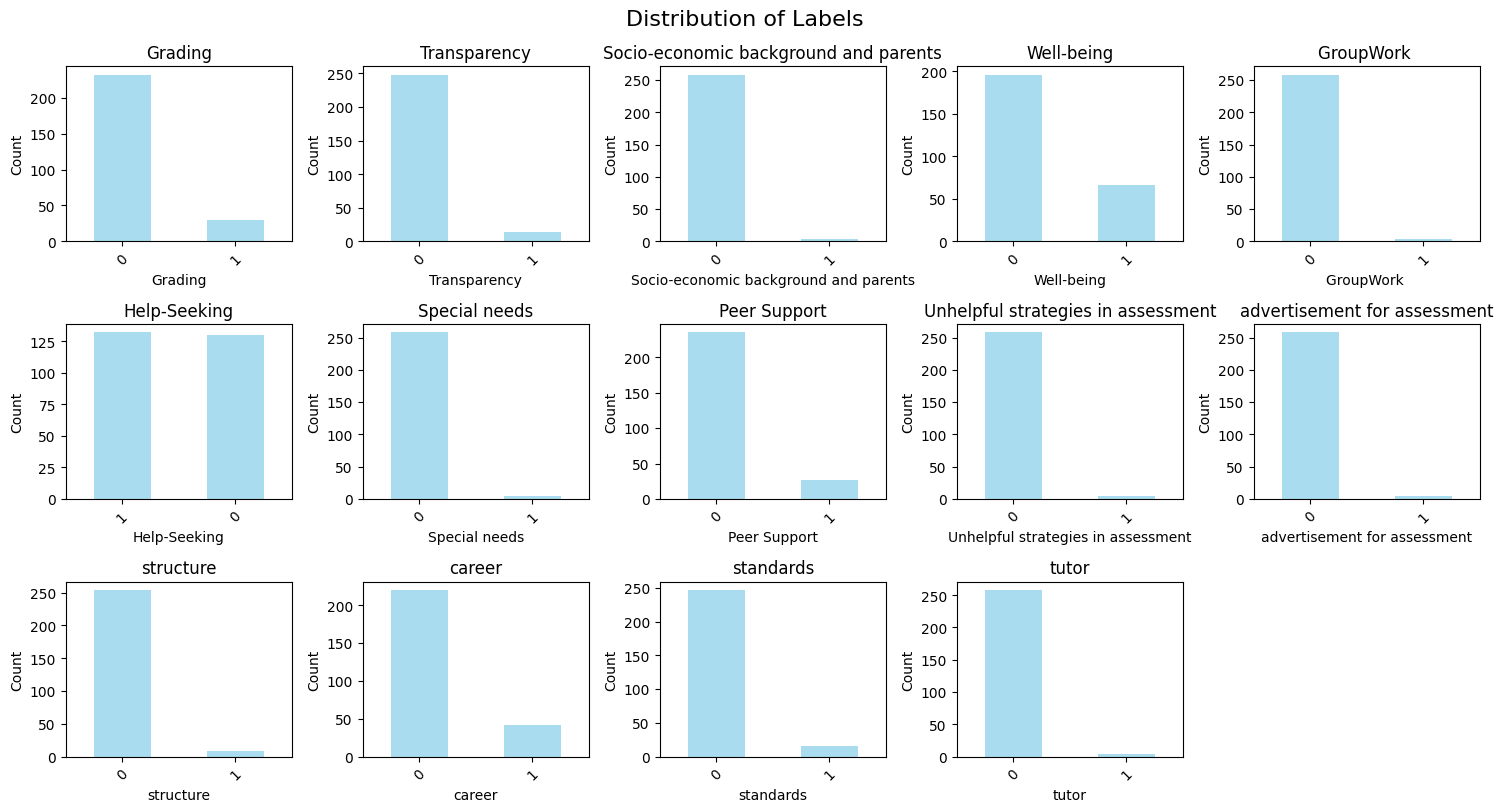

In [ ]:
plt.figure(figsize = (15,10))

for i,column in enumerate(label_columns,1):
  plt.subplot(4,5,i)
  data[column].value_counts().plot(kind='bar', color='skyblue', alpha=0.7)
  plt.title(column)
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.tight_layout()

plt.suptitle('Distribution of Labels', y=1.02, fontsize=16)
plt.show()

**Preprocessing**

In [ ]:
import re

class TextCleaner:
    def __init__(self):
        self.stop_words = {
            'lah', 'lor', 'leh', 'lor', 'lorh', 'aiyah', 'loh', 'eh', 'wa', 'lahs', 'siol', 'kiasu',
            'meh', 'lorrr','sibeh', 'dont', 'lo', 'sia', 'liao'
            'walao', 'bajet', 'wah', 'buay', 'thisone', 'gotmeh', 'la', 'leh', 'sibei',
            'hor', 'mah', 'meh', 'liao', 'sia', 'lahh', 'leh', 'alr', 'can', 'ar',
            'lahhh', 'ehh', 'aiyo', 'tsk', 'zzzz', 'haha', 'hehe', 'heh', 'hoh', 'meh', 'ooi',
            'alamak', 'chey', 'wahhh', 'mah', 'bah', 'liaos', 'zomg', 'zz', 'zzz'
        }
        self.contractions = {
            "ain't": "is not", "aint": "is not", "aren't": "are not", "arent": "are not",
            "can't": "cannot", "cant": "cannot", "couldn't": "could not", "couldnt": "could not",
            "didn't": "did not", "didnt": "did not", "doesn't": "does not", "doesnt": "does not",
            "don't": "do not", "dont": "do not", "hadn't": "had not", "hadnt": "had not",
            "hasn't": "has not", "hasnt": "has not", "haven't": "have not", "havent": "have not",
            "he'd": "he would", "hed": "he would", "he'll": "he will", "hell": "he will",
            "he's": "he is", "hes": "he is", "i'd": "i would", "id": "i would",
            "i'll": "i will", "ill": "i will", "i'm": "i am", "im": "i am",
            "i've": "i have", "ive": "i have", "isn't": "is not", "isnt": "is not",
            "it's": "it is", "its": "it is", "let's": "let us", "lets": "let us",
            "mightn't": "might not", "mightnt": "might not", "mustn't": "must not", "mustnt": "must not",
            "shan't": "shall not", "shant": "shall not", "she'd": "she would", "shed": "she would",
            "she'll": "she will", "shell": "she will", "she's": "she is", "shes": "she is",
            "shouldn't": "should not", "shouldnt": "should not", "that's": "that is", "thats": "that is",
            "there's": "there is", "theres": "there is", "they'd": "they would", "theyd": "they would",
            "they'll": "they will", "theyll": "they will", "they're": "they are", "theyre": "they are",
            "they've": "they have", "theyve": "they have", "wasn't": "was not", "wasnt": "was not",
            "we'd": "we would", "wed": "we would", "we're": "we are", "were": "we are",
            "weren't": "were not", "werent": "were not", "we've": "we have", "weve": "we have",
            "what'll": "what will", "whatll": "what will", "what're": "what are", "whatre": "what are",
            "what's": "what is", "whats": "what is", "what've": "what have", "whatve": "what have",
            "where's": "where is", "wheres": "where is", "who'd": "who would", "whod": "who would",
            "who'll": "who will", "wholl": "who will", "who're": "who are", "whore": "who are",
            "who's": "who is", "whos": "who is", "who've": "who have", "whove": "who have",
            "won't": "will not", "wont": "will not", "wouldn't": "would not", "wouldnt": "would not",
            "you'd": "you would", "youd": "you would", "you'll": "you will", "youll": "you will",
            "you're": "you are", "youre": "you are", "you've": "you have", "youve": "you have",
            "yk": "you know", "nah": "no", "yall": "you all", "idk": "i do not know",
            "idc": "i do not care", "btw": "by the way", "brb": "be right back",
            "lmk": "let me know", "omg": "oh my god", "tbh": "to be honest",
            "smh": "shaking my head", "imma": "i am going to", "gonna": "going to",
            "wanna": "want to", "gotta": "got to", "dunno": "do not know", "cuz": "because",
            "tho": "though", "thx": "thanks", "pls": "please", "kinda": "kind of",
            "lemme": "let me", "gimme": "give me", "yup": "yes", "nope": "no",
            "sup": "what is up", "rn": "right now", "bc": "because", "omw": "on my way",
            "hbu": "how about you", "wyd": "what are you doing", "wym": "what do you mean",
            "prolly": "probably", "nvm": "never mind", "imo": "in my opinion", "otot": "on time on target",
            "irl": "in real life", "b4": "before", "l8r": "later", "gr8": "great",
            "jk": "just kidding", "lol": "laugh out loud", "rofl": "rolling on the floor laughing",
            "bff": "best friend forever", "ttyl": "talk to you later", "liddat": "like that",
            "wahlao": "oh my", "sian": "bored", "bochap": "cannot be bothered", "paiseh": "embarrassed",
            "angmoh": "foreigner", "shiok": "great", "cheem": "deep or profound", "jialat": "in trouble",
            "kiasi": "scared to lose", "kiasu": "fear of missing out", "sabo": "sabotage",
            "alamak": "oh no", "chio": "pretty", "kopi": "coffee", "yalah": "yes indeed", "makan": "eat"
        }

    def expand_contractions(self, text):
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def remove_emoticons_and_emojis(self, text):
        emoticon_pattern = r"""
            (?:
                [<>]?
                [:;=8BXbx]                 # Eyes
                [\-oO\*\']?                # Optional nose
                [\)\]\(\[dDpP/\:\}\{@\|\\\$3*^~] # Mouth/Other
            )|
            (?:
                [\)\]\(\[dDpP/\:\}\{@\|\\\$3*^~] # Reverse emoticon mouth
                [\-oO\*\']?                 # Optional nose
                [:;=8BXbx][<>]?
            )|
            (?:<3|</?3|\\o/|\\O/|\\o\\|\\m/) # Common symbols (heart, gestures)
        """
        emoji_pattern = r"""
            [\U0001F600-\U0001F64F]  # Emoticons
            |[\U0001F300-\U0001F5FF]  # Symbols & Pictographs
            |[\U0001F680-\U0001F6FF]  # Transport & Map Symbols
            |[\U0001F700-\U0001F77F]  # Alchemical Symbols
            |[\U0001F780-\U0001F7FF]  # Geometric Shapes Extended
            |[\U0001F800-\U0001F8FF]  # Supplemental Arrows-C
            |[\U0001F900-\U0001F9FF]  # Supplemental Symbols and Pictographs
            |[\U0001FA00-\U0001FA6F]  # Chess Symbols
            |[\U0001FA70-\U0001FAFF]  # Symbols and Pictographs Extended-A
            |[\U00002702-\U000027B0]  # Dingbats
            |[\U000024C2-\U0001F251]  # Enclosed Characters
            |[\u2600-\u26FF]          # Miscellaneous Symbols
            |[\u2700-\u27BF]          # Dingbats
            |[\u2300-\u23FF]          # Miscellaneous Technical
            |[\u2B50-\u2B55]          # Stars and Other Symbols
            |[\u203C-\u2049]          # Exclamation Question Marks
            |[\u2190-\u21FF]          # Arrows
        """
        combined_pattern = f"{emoticon_pattern}|{emoji_pattern}"
        regex = re.compile(combined_pattern, re.VERBOSE | re.UNICODE)
        return regex.sub('', text)

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = self.expand_contractions(text)
        text = self.remove_emoticons_and_emojis(text)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
        text = re.sub(r"\S+@\S+", "", text)  # Remove emails
        text = re.sub(r"<.*?>", "", text) # Remove HTML Tags
        text = re.sub(r"[^a-zA-Z0-9\s.,()\"'!?-]", "", text) #Keep important punctuations
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        words = text.split(" ")
        cleaned_words = [word for word in words if word not in self.stop_words]  # Remove stopwords
        return ' '.join(cleaned_words)

# Example usage
cleaner = TextCleaner()
data["body"] = data["body"].apply(cleaner.clean_text)


In [ ]:
print(data.head().to_string())

   Unnamed: 0         id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

**Oversampling to Balance Data**

In [ ]:
random.seed(42)

X = data["body"]
Y = data[label_columns]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42, stratify = data["tutor"])

label_combinations = Y_train.apply(lambda row: tuple(row), axis=1)
combination_counts = Counter(label_combinations)

max_count = max(combination_counts.values())
oversampled_X = []
oversampled_Y = []

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_sentence = words.copy()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            if synonym != word_to_replace:
                new_sentence = [synonym if word == word_to_replace else word for word in new_sentence]
    return ' '.join(new_sentence)

augmented_X = []
augmented_Y = []


for combination, count in combination_counts.items():
    additional_samples = max_count - count
    if additional_samples > 0:
        matching_indices = label_combinations[label_combinations == combination].index
        for _ in range(additional_samples):
            original_text = X_train.loc[random.choice(matching_indices)]
            augmented_text = synonym_replacement(original_text, n=2)
            augmented_X.append(augmented_text)
            augmented_Y.append(list(combination))

oversampled_X.extend(augmented_X)
oversampled_Y.extend(augmented_Y)

balanced_data = pd.DataFrame({'body': oversampled_X})
balanced_labels = pd.DataFrame(oversampled_Y, columns=label_columns)
balanced_dataset = pd.concat([balanced_data, balanced_labels], axis=1)

balanced_label_distribution = balanced_dataset[label_columns].sum().sort_values(ascending=False)
balanced_label_distribution

,0
Well-being,341
Grading,313
career,222
Help-Seeking,217
standards,157
Peer Support,153
Socio-economic background and parents,119
structure,79
GroupWork,40
Unhelpful strategies in assessment,39


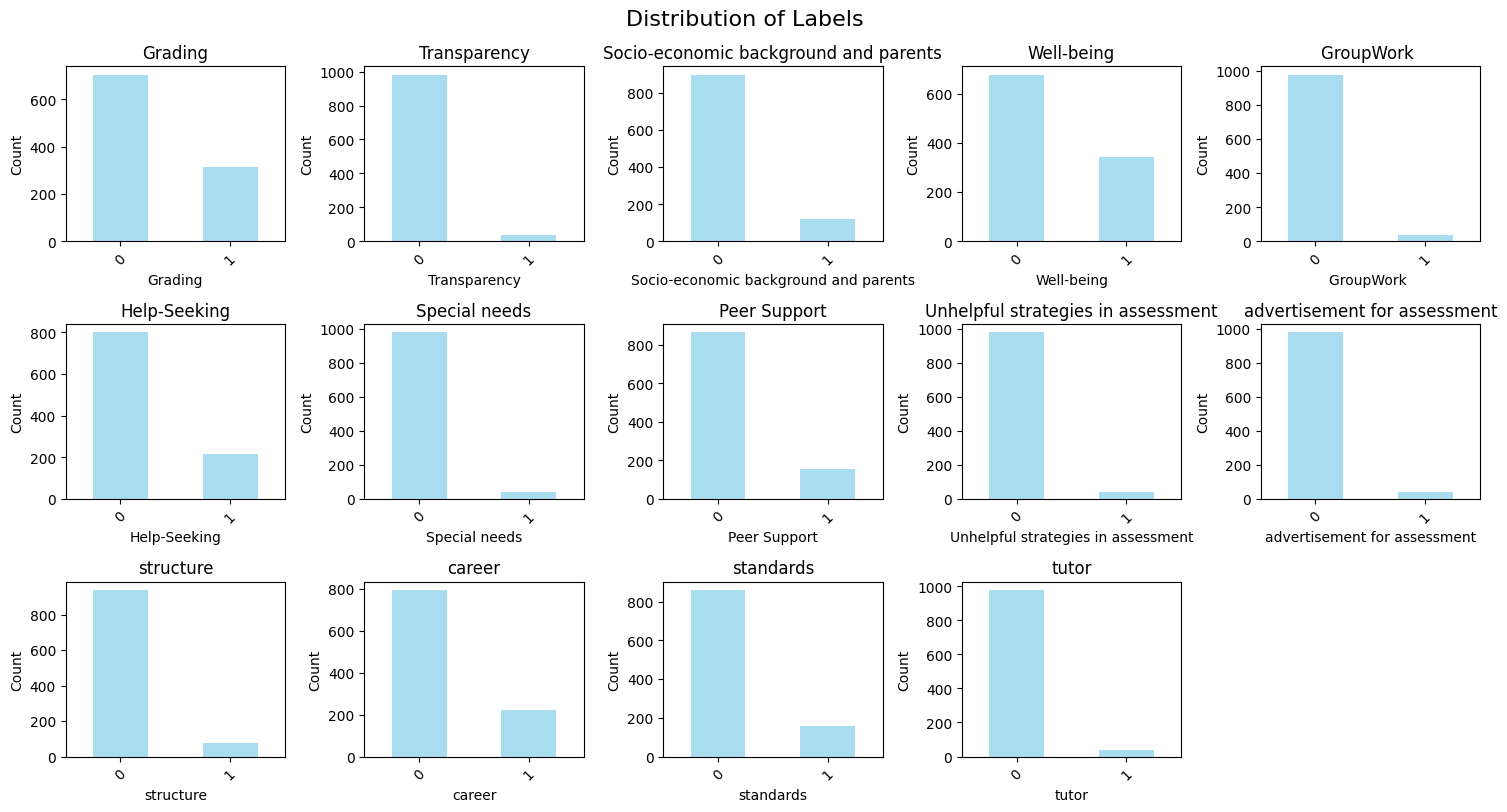

In [ ]:
plt.figure(figsize = (15,10))

for i,column in enumerate(label_columns,1):
  plt.subplot(4,5,i)
  balanced_dataset[column].value_counts().plot(kind='bar', color='skyblue', alpha=0.7)
  plt.title(column)
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.tight_layout()

plt.suptitle('Distribution of Labels', y=1.02, fontsize=16)
plt.show()

**Tokenize**

In [ ]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True)

class MultiLabelDataset(Dataset):
  def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
      item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
      return item

def tokenize_texts(texts, tokenizer, max_length=512):
  return tokenizer(
      list(texts),
      max_length=max_length,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
  )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_encodings = tokenize_texts(balanced_data["body"], tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

train_dataset = MultiLabelDataset(train_encodings,balanced_labels.values)
test_dataset = MultiLabelDataset(test_encodings, Y_test.values)

**Load Pretrained Model**

In [ ]:
class RobertaWithMultiLabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(RobertaWithMultiLabelClassification, self).__init__()
        self.num_labels = num_labels
        self.config = RobertaConfig.from_pretrained("roberta-base", num_labels=num_labels)
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.linear = torch.nn.Linear(768, 768)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_labels)

    def forward(self, input_ids, inputs_embeds, attention_mask, token_type_ids=None, labels = None, **kwargs):
        if inputs_embeds is not None:
            outputs = self.roberta(inputs_embeds=inputs_embeds, attention_mask=attention_mask, token_type_ids=token_type_ids)
        else:
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = outputs[0]
        pooler = hidden_state[:, 0]
        pooler = self.linear(pooler)
        pooler = self.activation(pooler)
        pooler = self.dropout(pooler)
        logits = self.classifier(pooler)
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return loss, logits

num_labels = 14
model = RobertaWithMultiLabelClassification(num_labels = 14)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Fine Tune with LoRA**

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"]
)

model = get_peft_model(model, lora_config)

**Training**

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_lora",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_lora",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to=["none"]  # Disable logging to external services
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset= test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.621900,0.607034,0.901309
2,0.402400,0.351284,0.901309
3,0.361900,0.311686,0.901309
4,0.348100,0.299964,0.901309
5,0.342400,0.294031,0.901309
6,0.325400,0.289574,0.901309
7,0.344700,0.287521,0.901309
8,0.321000,0.285972,0.901309
9,0.348300,0.285233,0.901309
10,0.323500,0.284563,0.901309


TrainOutput(global_step=1280, training_loss=0.38982448186725377, metrics={'train_runtime': 765.2679, 'train_samples_per_second': 13.289, 'train_steps_per_second': 1.673, 'total_flos': 0.0, 'train_loss': 0.38982448186725377, 'epoch': 10.0})